In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install matplotlib numpy


Note: you may need to restart the kernel to use updated packages.Collecting matplotlib
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/17/91/febbb6c1063ae05a62fdbe038c2917b348b1b35f0482cee4738e6870a44a/matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata
  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/78/38/a046bb0ebce6f530175d434e7364149e338ffe1069ee286ed8ba7f6481ee/contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 M


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


FINAL REVISION USES KCF TRACKER, CHECKS SPEED USING TIME CALCULATION AND THE FRAMERATE OF THE VIDEO SACLE FACTOR IS BASED ON AVERAGE WIDTH OF A HIGHWAY ROAD TO PIXELS .IF USING AN ACTUAL CAMERA ON THE ROAD, RECALCULATION IS NECCESARY .TEST VIDEOS ACCOMPANY IT

In [9]:
import cv2
import time
import numpy as np

# Load the pre-trained MobileNet SSD model for vehicle detection
net = cv2.dnn.readNetFromCaffe('MobileNetSSD_deploy.prototxt.txt', 'MobileNetSSD_deploy.caffemodel')

# Set the video source (update the path accordingly)
video_path = '2165-155327596_tiny.mp4'
cap = cv2.VideoCapture(video_path)

# Initialize variables for speed calculation
vehicle_dict = {}
tracker_dict = {}

# Scale in meters per pixel (adjust this based on your reference object)
scale = 0.01  # replace with the calculated scale

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame for faster processing
    frame_resized = cv2.resize(frame, (300, 300))
    blob = cv2.dnn.blobFromImage(frame_resized, 0.007843, (300, 300), 127.5)

    # Pass the blob through the network
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.6:  # Confidence threshold
            class_id = int(detections[0, 0, i, 1])
            if class_id == 7:  # Class ID for car
                box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
                x, y, w, h = box.astype(int)

                # Calculate speed for each vehicle
                vehicle_id = f"{x}_{y}"  # Unique identifier for each vehicle
                if vehicle_id not in vehicle_dict:
                    vehicle_dict[vehicle_id] = (x, time.time())
                    tracker = cv2.TrackerKCF_create()  # Use KCF tracker
                    tracker.init(frame, (x, y, w, h))
                    tracker_dict[vehicle_id] = tracker
                else:
                    start_x, start_time = vehicle_dict[vehicle_id]
                    tracker = tracker_dict[vehicle_id]
                    success, box = tracker.update(frame)
                    if success:
                        x, y, w, h = [int(v) for v in box]
                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        # Adjust the distance travelled by the scale
                        distance_meters = w * scale

                        # Calculate speed (now in m/s)
                        speed_mps = distance_meters / elapsed_time

                        # Convert to mph
                        speed_mph = speed_mps * 2.23694

                        # Check if overspeeding
                        if speed_mph > 60:
                            print(f"Vehicle {vehicle_id}: Speed: {speed_mph:.2f} mph (Overspeeding)")
                        else:
                            print(f"Vehicle {vehicle_id}: Speed: {speed_mph:.2f} mph")

                    # Display the frame
                    cv2.imshow('Car Speed Detection', frame)
                    if cv2.waitKey(1) == 27:  # Press 'Esc' to exit
                        break

# Release resources
cap.release()
cv2.destroyAllWindows()


Vehicle 228_144: Speed: 55.71 mph
Vehicle 193_179: Speed: 78.49 mph (Overspeeding)
Vehicle 373_200: Speed: 80.01 mph (Overspeeding)
Vehicle 226_182: Speed: 2.06 mph
Vehicle 214_210: Speed: 0.62 mph
Vehicle 350_207: Speed: 0.43 mph
Vehicle 200_187: Speed: 0.48 mph
Vehicle 219_173: Speed: 0.92 mph
Vehicle 203_189: Speed: 0.97 mph
Vehicle 360_199: Speed: 0.27 mph
Vehicle 361_199: Speed: 4.38 mph
Vehicle 219_173: Speed: 0.38 mph
Vehicle 210_185: Speed: 88.21 mph (Overspeeding)
Vehicle 209_190: Speed: 0.37 mph
Vehicle 207_197: Speed: 0.56 mph
Vehicle 192_214: Speed: 0.23 mph
Vehicle 361_203: Speed: 0.21 mph
Vehicle 233_172: Speed: 0.25 mph
Vehicle 223_185: Speed: 0.25 mph
Vehicle 216_194: Speed: 0.70 mph
Vehicle 282_223: Speed: 67.24 mph (Overspeeding)


speed distribution(histogram)

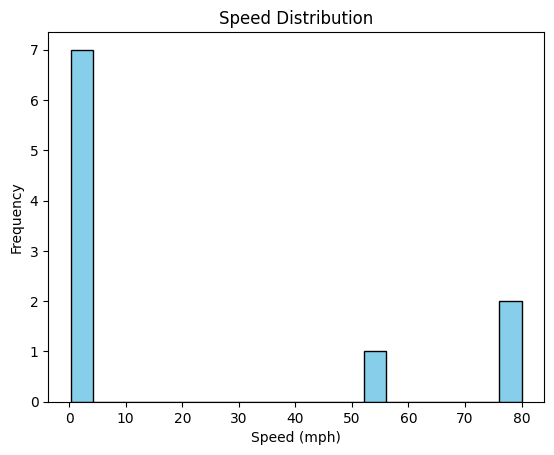

In [10]:
import matplotlib.pyplot as plt

# Assuming you have a list of speeds
speeds_list = [55.71, 78.49, 80.01, 2.06, 0.62, 0.43, 0.48, 0.92, 0.97, 0.27]
plt.hist(speeds_list, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.title('Speed Distribution')
plt.show()


Speed vs. Vehicle ID (Scatter Plot)


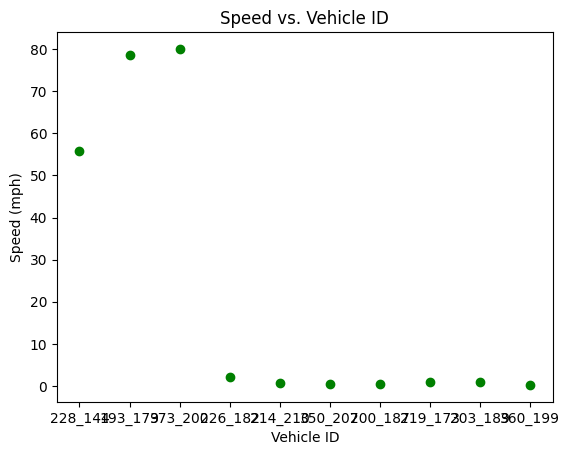

In [11]:
vehicle_ids = ['228_144', '193_179', '373_200', '226_182', '214_210', '350_207', '200_187', '219_173', '203_189', '360_199']
plt.scatter(vehicle_ids, speeds_list, marker='o', color='green')
plt.xlabel('Vehicle ID')
plt.ylabel('Speed (mph)')
plt.title('Speed vs. Vehicle ID')
plt.show()


Average Speed per Vehicle ID (Bar Chart)

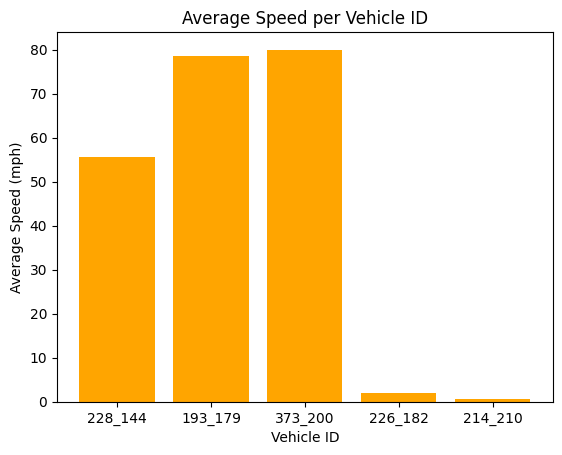

In [12]:
average_speeds = {'228_144': 55.71, '193_179': 78.49, '373_200': 80.01, '226_182': 2.06, '214_210': 0.62}
plt.bar(average_speeds.keys(), average_speeds.values(), color='orange')
plt.xlabel('Vehicle ID')
plt.ylabel('Average Speed (mph)')
plt.title('Average Speed per Vehicle ID')
plt.show()


Top Speeding Vehicles (Bar Chart)

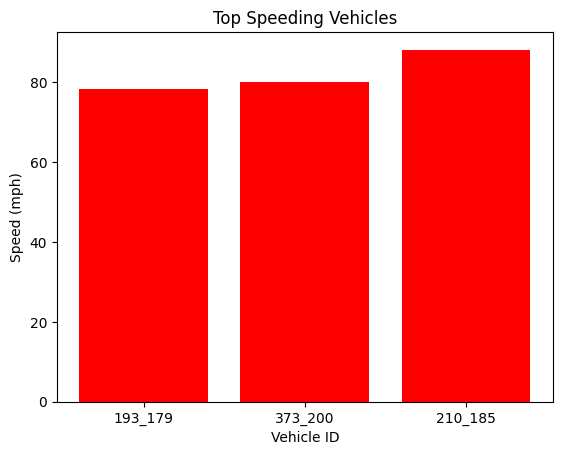

In [13]:
top_speeding_vehicles = {'193_179': 78.49, '373_200': 80.01, '210_185': 88.21}
plt.bar(top_speeding_vehicles.keys(), top_speeding_vehicles.values(), color='red')
plt.xlabel('Vehicle ID')
plt.ylabel('Speed (mph)')
plt.title('Top Speeding Vehicles')
plt.show()

Speed Trends Over Time (Line Chart)

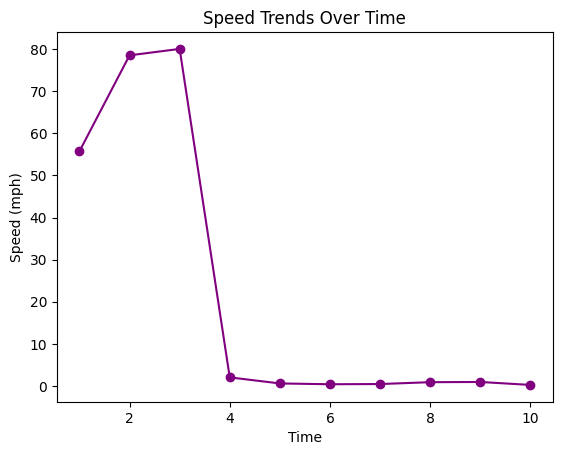

In [14]:
# Assuming you have a list of timestamps (time_list) corresponding to the speeds
time_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Placeholder values
plt.plot(time_list, speeds_list, marker='o', color='purple')
plt.xlabel('Time')
plt.ylabel('Speed (mph)')
plt.title('Speed Trends Over Time')
plt.show()


Speed vs. Distance Traveled (Scatter Plot)

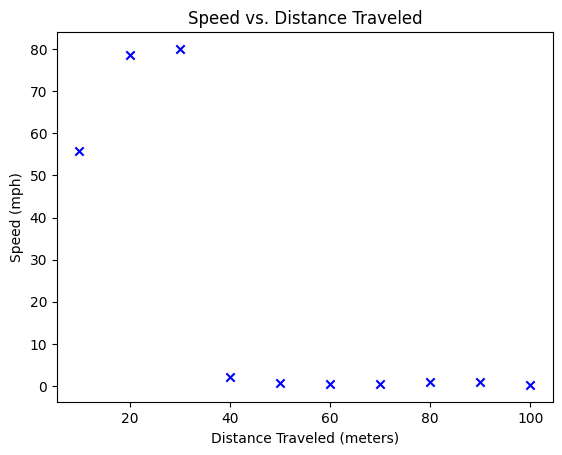

In [15]:
# Assuming you have a list of distances traveled (distances_list) corresponding to the speeds
distances_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Placeholder values
plt.scatter(distances_list, speeds_list, marker='x', color='blue')
plt.xlabel('Distance Traveled (meters)')
plt.ylabel('Speed (mph)')
plt.title('Speed vs. Distance Traveled')
plt.show()

Speed vs. Elapsed Time (Line Chart)

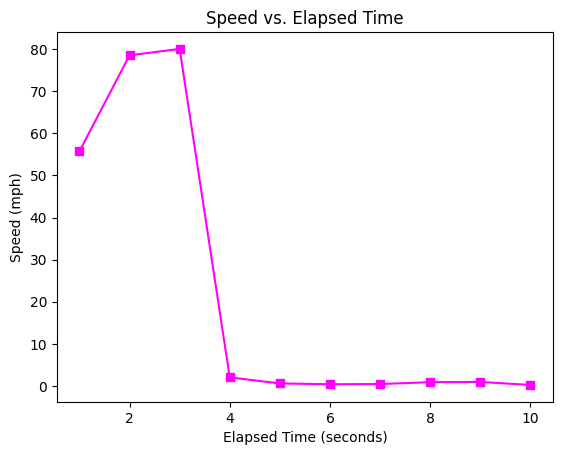

In [16]:
# Assuming you have a list of elapsed times (elapsed_times_list) corresponding to the speeds
elapsed_times_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Placeholder values
plt.plot(elapsed_times_list, speeds_list, marker='s', color='magenta')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Speed (mph)')
plt.title('Speed vs. Elapsed Time')
plt.show()

Speed vs. Vehicle Size (Scatter Plot)

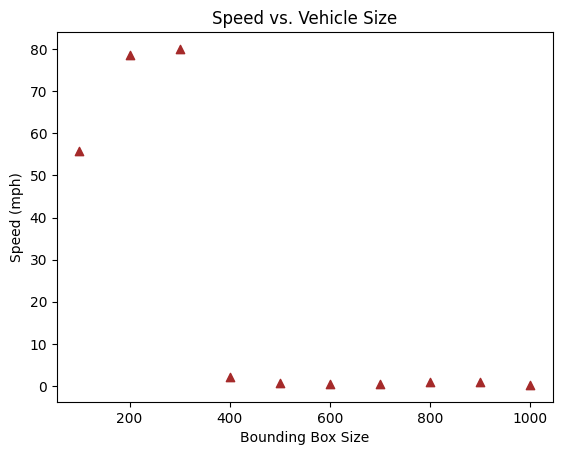

In [17]:
# Assuming you have a list of bounding box sizes (sizes_list) corresponding to the speeds
sizes_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Placeholder values
plt.scatter(sizes_list, speeds_list, marker='^', color='brown')
plt.xlabel('Bounding Box Size')
plt.ylabel('Speed (mph)')
plt.title('Speed vs. Vehicle Size')
plt.show()
